<a href="https://colab.research.google.com/github/sreyareddy15/Time-series-forecasting-google_stocks/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries 

In [ ]:
!pip install chart-studio

In [180]:
# Importing libraries
# check which ones you really need remove unused imports
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

#  Overview of problems where time series is used
1. Stock prices and other economic indicators
2. Weather data analysis and prediction( humidity, temperature prediction, storm analysis)
3. Health and fitness tracking data( heart rate, human activity recognition)
4. Transportation data( analysis of reasons for delay, performance and maintainance indicators analysis)
5. Devops logs and health data( developing an AIOPS solution for use cases like anomaly detection, prediction of failures, distinguish between actual failures and warnings )
6. Sports Analysis( player/team form analysis, calculating performance ratings, predicting next match outcome)


#### We have used google stocks data to perform time series forecasting and we have used various statistical models and deep learning model to predict future values 

#  1.Data Preprocessing  

## 1.1 Importing time series data

Dataset : [google stocks](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [411]:
google = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [678]:
google.shape

(3019, 5)

There are 3019 samples with 6 features

## 1.2 Cleaning and preparing time series data


Google stocks data doesn't have any missing values ,so there is no need of cleaning data. <br/>
We should remove "Name" column as all data belongs to google itself

In [412]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [414]:
google.drop('Name',axis=1,inplace=True)

## 1.3 Visualizing the datasets

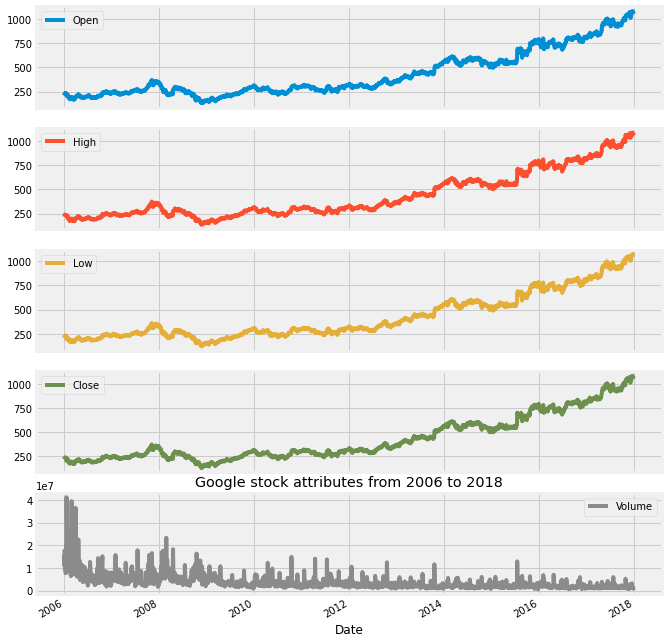

In [103]:
google['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2006 to 2018')
plt.savefig('stocks.png')
plt.show()

### Inference 
From the above figure, we can see the trend in google stocks for every feature like High,Low,Close,volume 

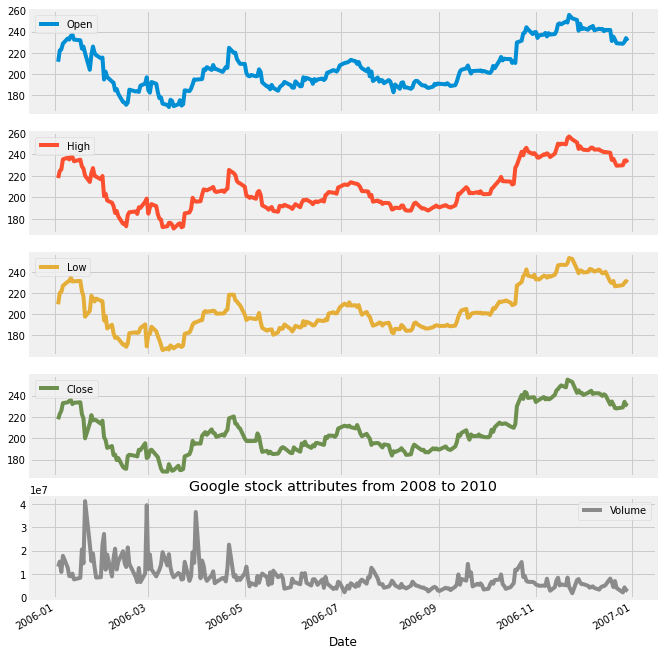

In [11]:
# for single year
google['2006':'2006'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## 1.4 Autocorrelation and Partial Autocorrelation
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 



### Autocorrelation

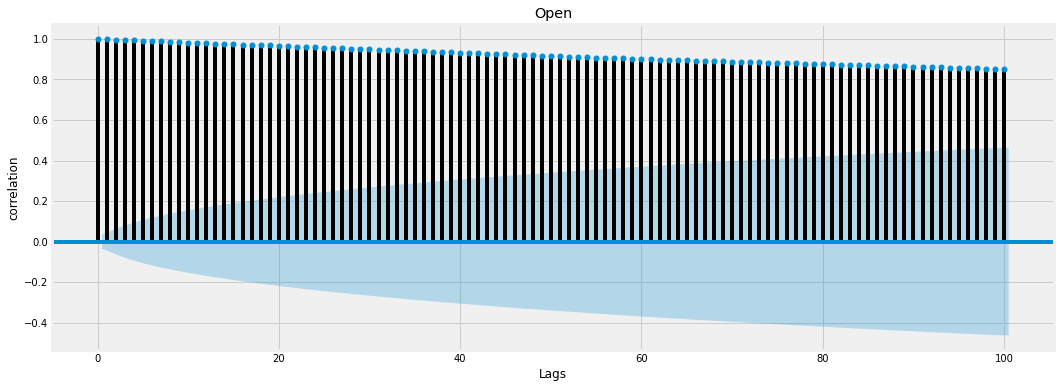

In [680]:
# Autocorrelation of google of high
plot_acf(google["Open"],lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

 As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.


### Partial Autocorrelation

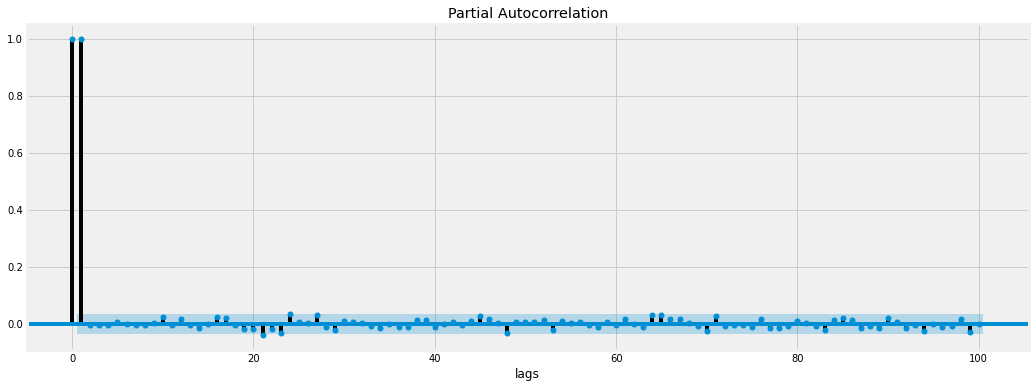

In [681]:
# Partial Autocorrelation of google of High
plot_pacf(google["Open"],lags=100)
plt.xlabel('lags')
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low.

## 1.5. Trends, seasonality and noise
These are the components of a time series
* Trend - Consistent upwards or downwards slope of a time series - this will help us to see clear pattern in data
* Seasonality - Clear periodic pattern of a time series(like sine funtion) - can know wthere the change is uniform or not
* Noise - Outliers or missing values - there may be some outliers due to unexpected events in particular time

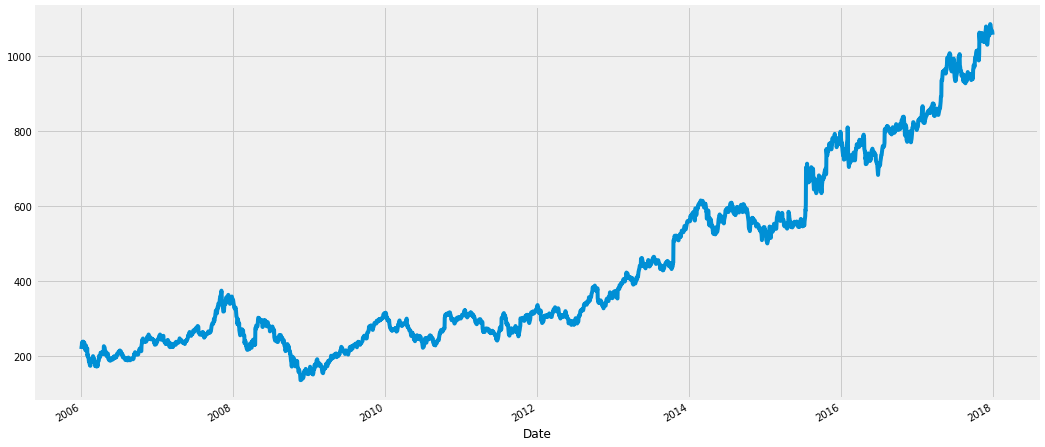

In [30]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

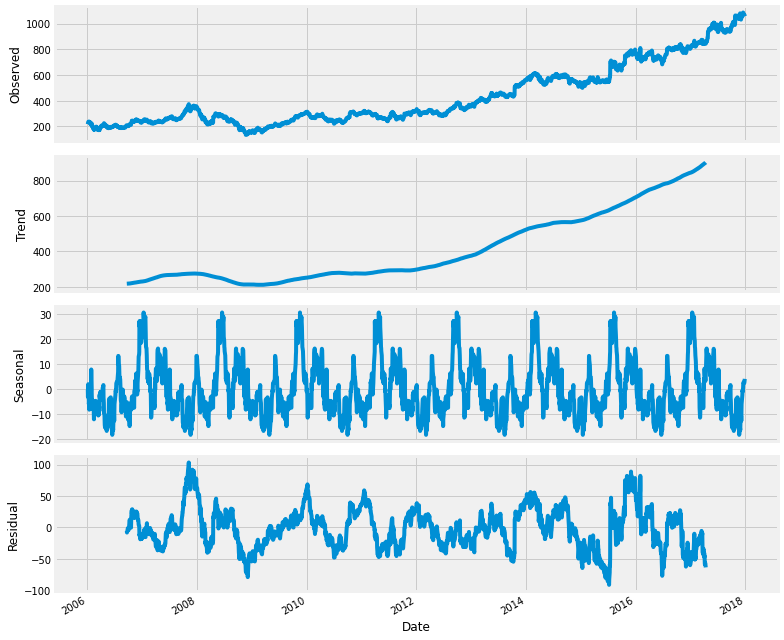

In [31]:
# Now, for decomposition...
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

* There is clearly an upward trend in the above plot.
* You can also see the uniform seasonal change.
* Non-uniform noise that represent outliers and missing values
* when the data has highly varying trend ,it is not stationary

# 2.Modelling using statstools and deep learning model

## For **opening** values of google stocks

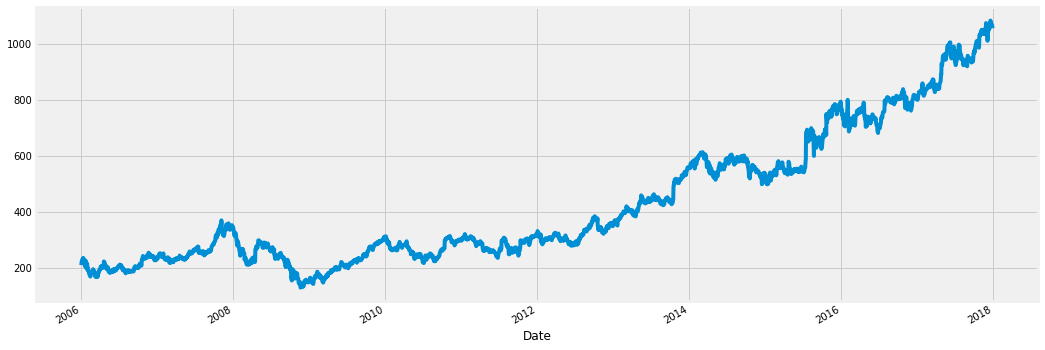

In [105]:
# plot of opening data
google['Open'].plot()

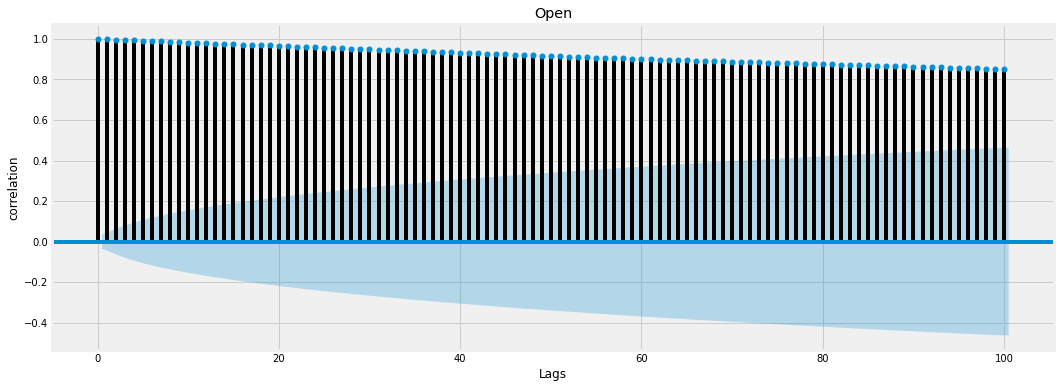

In [557]:
# Autocorrelation of google of Open
plot_acf(google['Open'],lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

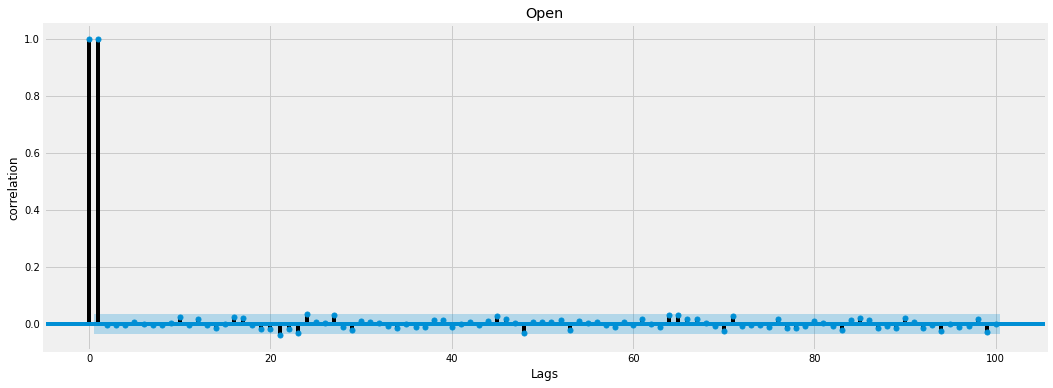

In [558]:
# Autocorrelation of google of Open
plot_pacf(google['Open'],lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

when ACF graph gradually reduces and PACF graph suddenly cut down to 0 then we should generally prefer AR model and vice-versa for MA model <br/>
We have implemented all the models for comparision. <br/>
Also from ACF , we can know whether data is stationary or not.
If the graph of ACF looks like above,that is gradually decreases to 0 then the time series data is non-stationary . <br/>
If the graph of ACF looks something like PACF graph above then data is stationary. <br/>
ARMA ,ARIMA models only works on stationary time series data , so we have to change data into stationary data

we can change non-stationary data into stationary using various methods.one of them is taking difference of data between 2 dates instead of every day data

In [682]:
data = google['Open'].diff()
data.fillna(method='bfill',inplace=True)

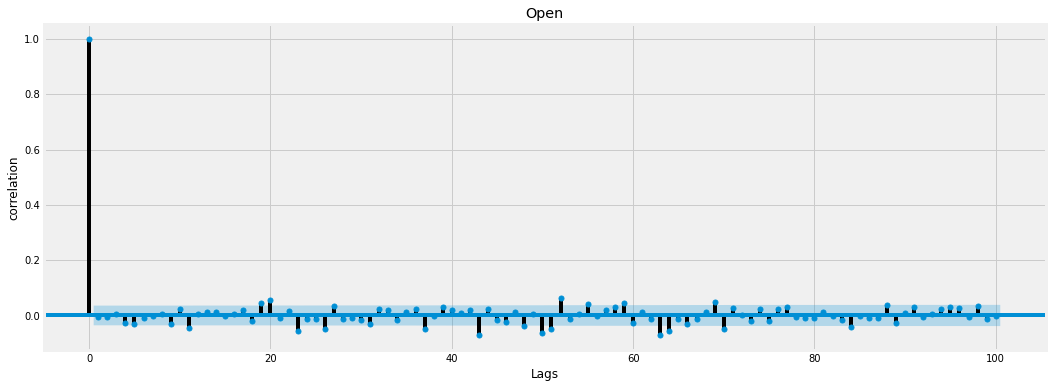

In [564]:
# Autocorrelation of google of high
plot_acf(data,lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

we can see ACF graph has changed

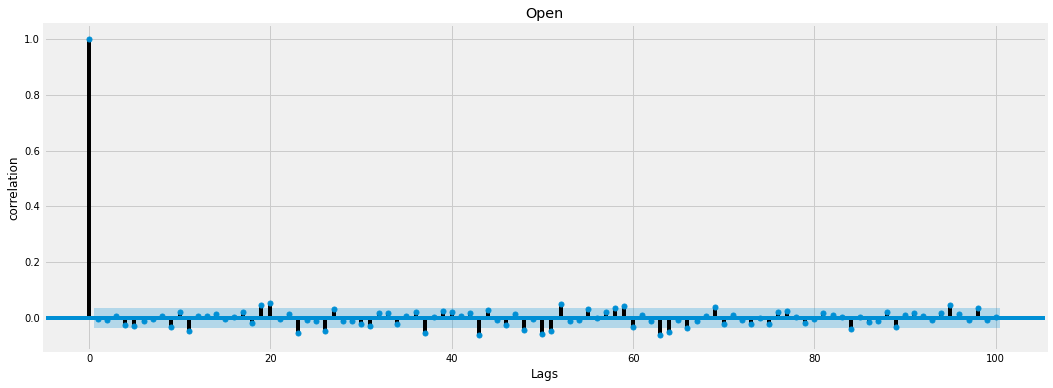

In [644]:
# Autocorrelation of google of high
plot_pacf(data,lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

 We can observe PACF has also suddenly reached 0 , so we have to do both AR ,MA models to compare and see which one will work best

### 2.1.1 AR models

 #### AR(1) model
 R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>
 ##### As RHS has only one lagged value(R<sub>t-1</sub>)this is called AR model of order 1 where μ is mean and ε is noise at time t
 #### AR(2) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>
 #### AR(3) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

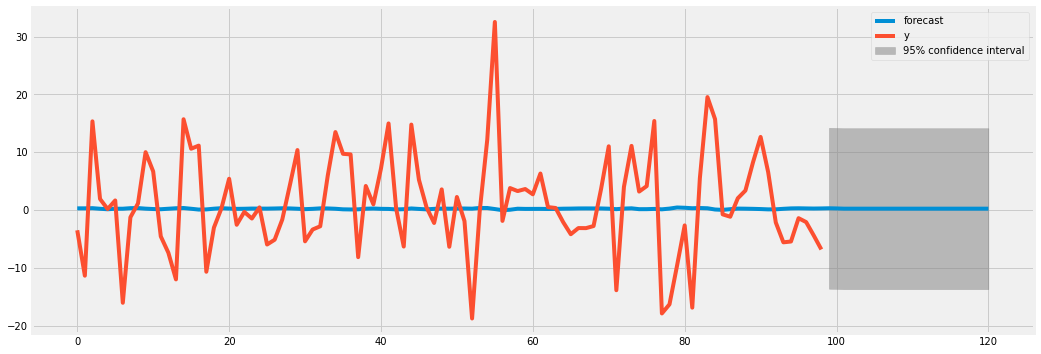

In [565]:
# Predicting Opening value of google
# AR(1) model 
rcParams['figure.figsize'] = 16, 6
open_AR = ARMA(data.iloc[1:].values, order=(2,0))
res_open_AR = open_AR.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_AR.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [624]:
rmse_open_AR = math.sqrt(mean_squared_error(data.iloc[(3019-100):3019].values, res_open_AR.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_AR))

The root mean squared error is 8.697171002039003.


In [625]:
print ( 'AR model summary for google Opening stock value ')
print(res_open_AR.summary())
print("μ={} ,θ={}".format(res_open_AR.params[0],res_open_AR.params[1:]))

AR model summary for google Opening stock value 
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(2, 0)   Log Likelihood              -10191.592
Method:                       css-mle   S.D. of innovations              7.085
Date:                Wed, 05 May 2021   AIC                          20391.184
Time:                        15:01:27   BIC                          20415.233
Sample:                             0   HQIC                         20399.832
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2797      0.127      2.194      0.028       0.030       0.529
ar.L1.y       -0.0058      0.018     -0.317      0.751      -0.041       0.030
ar.

### 2.1.2 MA models

#### MA(1) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θϵ<sub>t-1</sub>

It translates to Today's returns = mean + today's noise + yesterday's noise
##### As there is only 1 lagged value in RHS, it is an MA model of order 1

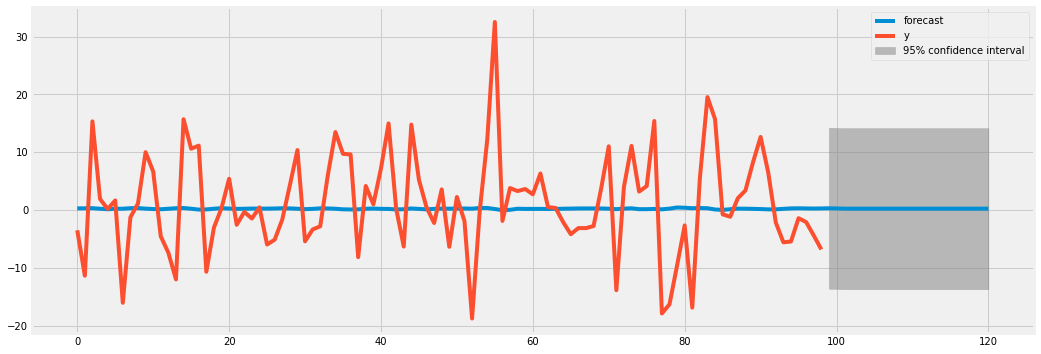

In [569]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_MA = ARMA(data.iloc[1:].values, order=(0,2))
res_open_MA = model_open_MA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_MA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [631]:
rmse_open_MA = math.sqrt(mean_squared_error(data.iloc[(3019-100):3019].values, res_open_MA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_MA))

The root mean squared error is 8.697110074558754.


In [627]:
print(res_open_MA.summary())
print("μ={} ,θ={}".format(res_open_MA.params[0],res_open_MA.params[1:]))


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(0, 2)   Log Likelihood              -10191.590
Method:                       css-mle   S.D. of innovations              7.085
Date:                Wed, 05 May 2021   AIC                          20391.180
Time:                        15:01:42   BIC                          20415.229
Sample:                             0   HQIC                         20399.828
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2797      0.127      2.195      0.028       0.030       0.529
ma.L1.y       -0.0057      0.018     -0.314      0.754      -0.041       0.030
ma.L2.y       -0.0063      0.019     -0.335      0.7



### 2.1.3 ARMA models

### ARMA(1,1) model
### R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 
Basically, Today's return = mean + Yesterday's return + noise + yesterday's noise.

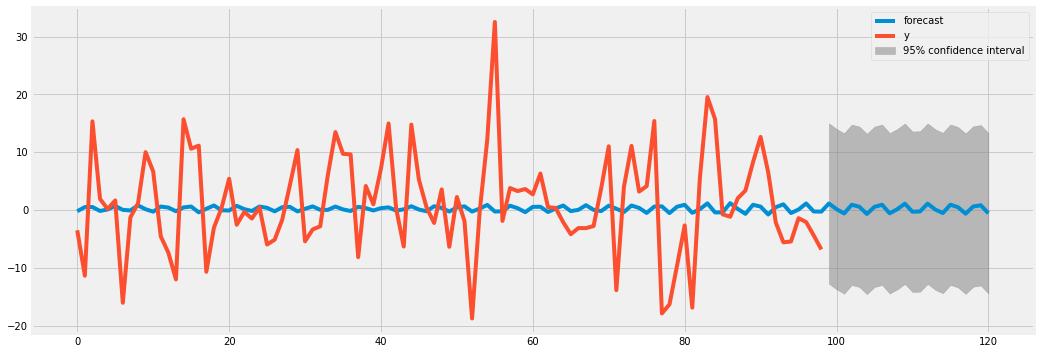

In [628]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_ARMA = ARMA(data.iloc[1:].values, order=(2,2))
res_open_ARMA = model_open_ARMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [629]:
rmse_open_ARMA = math.sqrt(mean_squared_error(data.iloc[(3019-100):3019].values, res_open_ARMA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_ARMA))

The root mean squared error is 8.709505400203472.


In [632]:
print(res_open_ARMA.summary())

print('Parameters:')
print('μ={},ϕ={},θ={}'.format(res_open_ARMA.params[0],res_open_ARMA.params[1:3],res_open_ARMA.params[3:5]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(2, 2)   Log Likelihood              -10183.215
Method:                       css-mle   S.D. of innovations              7.065
Date:                Wed, 05 May 2021   AIC                          20378.429
Time:                        15:02:39   BIC                          20414.504
Sample:                             0   HQIC                         20391.401
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2798      0.128      2.184      0.029       0.029       0.531
ar.L1.y       -0.7188      0.007   -101.744      0.000      -0.733      -0.705
ar.L2.y       -0.9923      0.005   -184.188      0.0

### 2.1.4 ARIMA models

ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter
### ARIMA(1,0,0)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>**
### ARIMA(1,0,1)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>**
### ARIMA(1,1,1)
**Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>** where **Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>**

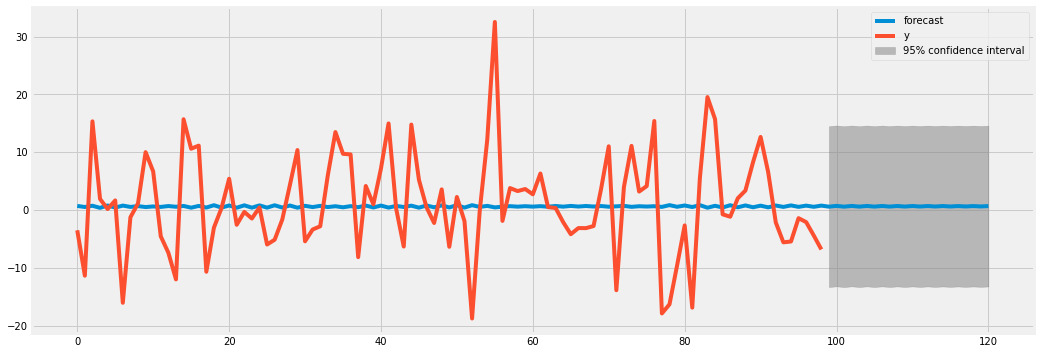

In [633]:
rcParams['figure.figsize'] = 16, 6
# Forecasting and predicting Google Opening values
model_open_ARIMA = ARIMA(data.iloc[1:].values, order=(2,1,2))
res_open_ARIMA = model_open_ARIMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARIMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [634]:
rmse_open_ARIMA = math.sqrt(mean_squared_error(data.iloc[(3019-100):3019].values, res_open_ARIMA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_ARIMA))

The root mean squared error is 17.308243872502487.


In [635]:
print(res_open_ARIMA.summary())

print('Parameters:')
print('μ={},ϕ={},θ={}'.format(res_open_ARIMA.params[0],res_open_ARIMA.params[1:3],res_open_ARIMA.params[3:5]))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10190.566
Method:                       css-mle   S.D. of innovations              7.081
Date:                Wed, 05 May 2021   AIC                          20393.131
Time:                        15:03:08   BIC                          20429.203
Sample:                             1   HQIC                         20406.102
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.835      0.067   -1.84e-05       0.001
ar.L1.D.y     -0.9636      0.052    -18.595      0.000      -1.065      -0.862
ar.L2.D.y     -0.0009      0.019     -0.048      0.9

### 2.1.5 LSTM models

In [636]:
# function which plots google stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real GOOGLE stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("GOOGLE stock price prediction")
    plt.xlabel("time")
    plt.ylabel("GOOGLE stock price")
    plt.legend()
    plt.show()


In [586]:
train = data[:'2016'].values.reshape(-1,1)
test = data['2017':].values.reshape(-1,1)


In [582]:
# scaling the training set

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [587]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2768):
    x_train.append(train[i-60:i, 0])
    y_train.append(train[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [588]:
print('x:',x_train[0],'y:',y_train[0])

x: [ 10.7   10.7    1.05   5.44   4.78  -1.     3.43   1.23  -4.71  -0.63
  -7.89   1.94  -6.24 -15.68  14.34   7.63  -5.87  -2.27  -2.89   0.67
 -20.79   7.4   -5.1   -4.16  -1.16  -7.27   1.37  -4.63  -7.67  -0.65
  -2.03   2.2   12.1   -1.71   0.36  -0.77   5.85   1.99   5.97 -12.34
  -2.14  10.02  -1.69  -7.96  -5.55   0.73  -5.95  -1.28  -1.9    6.82
  -1.08  -4.91   1.77   3.84  -5.14   1.31  13.14  -0.76   2.31   4.12] y: 4.6299999999999955


In [589]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [590]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(units=1))

In [591]:
# compiling the LSTM RNN network

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit to the training set

regressor.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
85/85 [==============================] - 16s 104ms/step - loss: 47.0919
Epoch 2/10
85/85 [==============================] - 9s 106ms/step - loss: 44.2130
Epoch 3/10
85/85 [==============================] - 9s 106ms/step - loss: 45.1922
Epoch 4/10
85/85 [==============================] - 9s 106ms/step - loss: 45.0149
Epoch 5/10
85/85 [==============================] - 9s 107ms/step - loss: 48.6388
Epoch 6/10
85/85 [==============================] - 9s 106ms/step - loss: 51.5127
Epoch 7/10
85/85 [==============================] - 9s 107ms/step - loss: 45.2397
Epoch 8/10
85/85 [==============================] - 9s 107ms/step - loss: 48.7595
Epoch 9/10
85/85 [==============================] - 9s 107ms/step - loss: 42.8012
Epoch 10/10
85/85 [==============================] - 9s 108ms/step - loss: 48.7864


In [592]:

dataset_total = pd.concat((google['Open'][:'2016'], google['Open']['2017':]), axis=0)
print(dataset_total.shape);

inputs = dataset_total.values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)

(3019,)
(3019,)
(3019, 1)
(3019, 1)


In [638]:
# preparing x_test

x_test = []
for i in range(3020-100,3020):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(100, 60, 1)

In [639]:
# predicting the stock prices for test set

predicted = regressor.predict(x_test)
predicted = sc.inverse_transform(predicted)

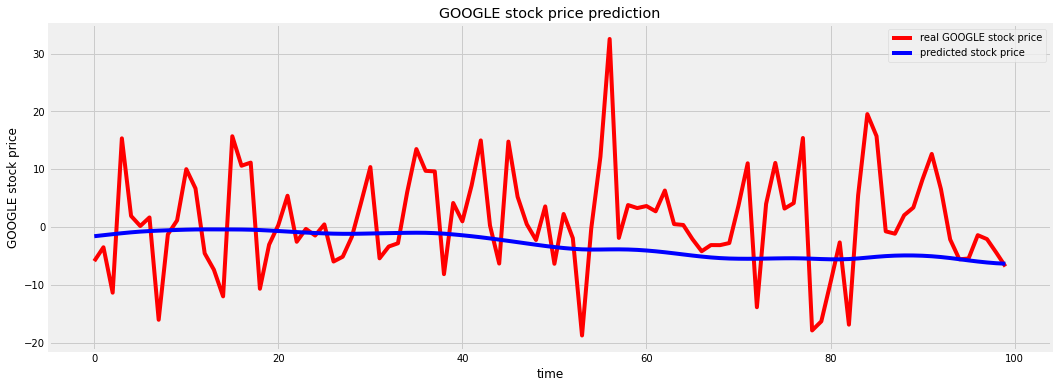

In [641]:
# visualizing the results: predicted vs test
rcParams['figure.figsize'] = 16, 6
test = data.values
plot_predictions(test[-100:], predicted)

In [642]:
rmse_LSTM =  math.sqrt(mean_squared_error(test[-100:], predicted))

###  2.1.6 Comparision of models 

We have used 'rmse' as the parameter to compare 5 models

In [643]:
print('rmse of AR(1) model        : ',rmse_open_AR)
print('rmse of MA(1) model        : ',rmse_open_MA)
print('rmse of ARMA(2,2) model    : ',rmse_open_ARMA)
print('rmse of ARIMA(2,1,2) model : ',rmse_ARIMA)
print('rmse of LSTM model         : ',rmse_LSTM)

rmse of AR(1) model        :  8.697171002039003
rmse of MA(1) model        :  8.697110074558754
rmse of ARMA(2,2) model    :  8.709505400203472
rmse of ARIMA(2,1,2) model :  16.92375963631688
rmse of LSTM model         :  9.66015274347485


We can observe that MA(1) has less RMSE value , let's see the final model
<br/>
We can also see that AR(1) model is also equally better as rmse values are so close to each other

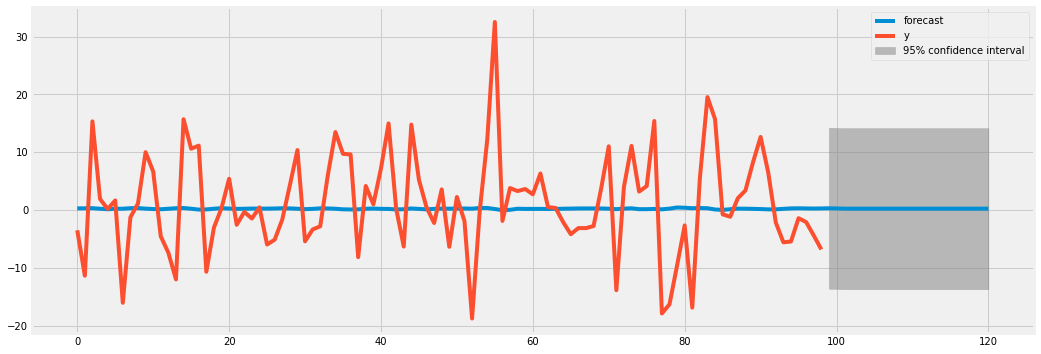

In [647]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_ARMA = ARMA(data.iloc[1:].values, order=(0,2))
res_open_ARMA = model_open_ARMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

The above graph is of difference of 'opening' data. <br/>
Let's see how it works on actual data

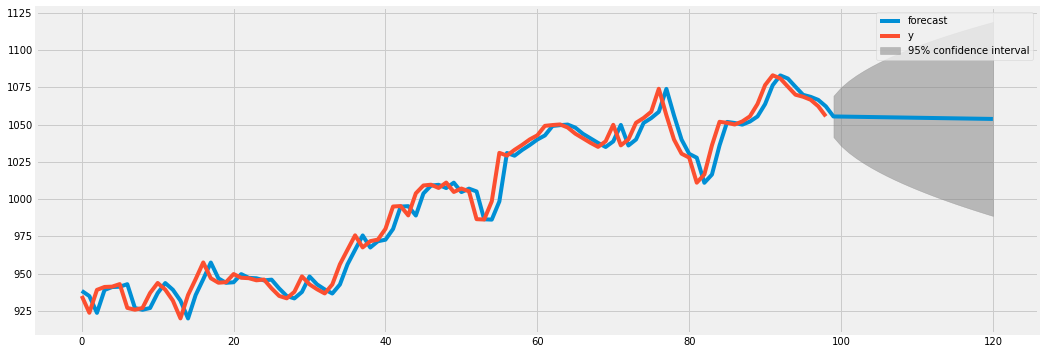

In [667]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_ARMA = ARMA(google['Open'].iloc[1:].values, order=(1,0))
res_open_ARMA = model_open_ARMA.fit()

# let's predict for last 100 days of data provided and next 20 days
res_open_ARMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

## Other Features
The process is same for other time series data also that is 'closing price','high value','low value' as the pattern of data was which we have observed in visualization part. <br/>
